In [13]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# 시각화 한글 깨짐 방지 설정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams["axes.unicode_minus"] = False




In [14]:
MAX_PAGES_TO_SCRAPE = 20  # 수동으로 크롤링할 최대 페이지 수 (약 500개 데이터)

try:
    # 1. 브라우저 실행
    driver = webdriver.Chrome()
    driver.maximize_window()
    driver.get("https://prod.danawa.com/list/?cate=112758")
    time.sleep(3)
    
    print("페이지 로딩 완료")
    
    # 2. 체크박스 선택 (공백 제거하고 비교)
    # 2. ul > li > label 구조에서 title 속성으로 찾기
    target_brands = ['삼성전자', 'LG전자', 'APPLE']
    
    # ul.item_list 안의 모든 li 찾기
    li_elements = driver.find_elements(By.CSS_SELECTOR, 'ul.item_list.item_list_popular > li.sub_item')

    for li in li_elements:
        try:
            label = li.find_element(By.TAG_NAME, 'label')

            # title 속성 값 가져오기
            title = label.get_attribute('title')
            
            # title이 None이면 건너뛰기
            if not title:
                continue
            # 공백 제거
            title = title.strip()
            
            # target_brands에 있으면 클릭
            if title in target_brands:
                driver.execute_script("arguments[0].scrollIntoView(true);", label)
                time.sleep(0.3)
                driver.execute_script("arguments[0].click();", label)
                print(f"✓ {title} 체크박스 선택 완료")
                time.sleep(0.5)
        
        except Exception as e:
            continue 

        # print(f"✗ {brand} 선택 실패: {e}")
    
    print("\n필터 적용 대기 중...")
    time.sleep(3)
        
    # # 3. 현재 페이지 HTML 가져오기
    # html = driver.page_source
    # soup = BeautifulSoup(html, "html.parser")

    print("크롤링 준비 완료!")
    
except Exception as e:
    print(f"에러 발생: {e}")

finally:
    pass




페이지 로딩 완료
✓ LG전자 체크박스 선택 완료
✓ 삼성전자 체크박스 선택 완료
✓ APPLE 체크박스 선택 완료

필터 적용 대기 중...
크롤링 준비 완료!


In [15]:
import re 
# 상품 정보 추출

# ul class="product_list" 내에 li class="prod_item" 

# products = [] # 상품한개 정보 
# product_list = soup.select('ul.product_list > li.prod_item') # 한 페이지 상품 정보
all_products_data = [] # 전체 상품 데이터

# 반복문으로 각각 타겟, 피처 변수들 모델명, 화면 크기, 무게, os, cpu, 그래픽, 램, 용량, 배터리, 최저가, 등록 년월, 평점, 댓글개수

# pager_ul = soup.select_one("div.num_nav_rap") # entire 변수 대신 직접 select_one 사용

# if pager_ul:
#     text = pager_ul.select_one("li.current").get_text(strip=True)
#     parts = text.split()
#     total_pages = int(parts[3])
# else:
#     # 페이지네이션이 없는 경우를 대비하여 최소 1페이지로 설정
#     total_pages = 1

# 페이징도 onclick="javascript:movePage() 함수로 자동화 하는 방법 수동방식이 있다고 함 "
# 한 화면당 30개 데이터이니 한 20개페이지까지만 페이징 해서 데이터 수집


for current_page in range(1, MAX_PAGES_TO_SCRAPE + 1):
        
    print(f"\n{'='*60}")
    print(f"📄 {current_page}페이지 크롤링 중...")
    print(f"{'='*60}")
    
    # 현재 페이지 HTML 가져오기
    time.sleep(2)
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")
    
    # ul class="product_list" 내에 li class="prod_item"
    product_list = soup.select('ul.product_list > li.prod_item')
    
    if not product_list:
        print("더 이상 제품이 없습니다.")
        break
    
    print(f"현재 페이지 제품 수: {len(product_list)}개")
        
    # 반복문으로 각각 타겟, 피처 변수들 추출
    for idx, product in enumerate(product_list, 1):
        
        product_main = product.select_one("div.prod_main_info")
        product_data = {}

        if not product_main:
            continue

        # 모델명
        name_elem = product_main.select_one("p.prod_name a")
        if not name_elem:
            continue
        
        name = name_elem.get_text(strip=True)
        product_data['모델명'] = name

        spec_divs = product_main.select_one("div.spec_list")
        
        if not spec_divs:
            continue

        spec_text = spec_divs.get_text(strip=True)
        
        # 화면 크기
        screen_match = re.search(r'(\d+\.?\d*)\s*인치|(\d+\.?\d*)cm\s*\((\d+\.?\d*)인치\)', spec_text)
        if screen_match:
            product_data['화면크기'] = screen_match.group(3) if screen_match.group(3) else screen_match.group(1)
        else:
            product_data['화면크기'] = ''
        
        # 무게
        weight_match = re.search(r'(\d+\.?\d*)\s*kg', spec_text)
        product_data['무게'] = weight_match.group(1) if weight_match else ''

        # CPU
        cpu_found = ''
        cpu_patterns = [
            r'(인텔|intel|코어|core|i\d|울트라\d)\s*[\w\-\s]+',
            r'(amd|라이젠|ryzen)\s*[\w\-\s]+',
            r'm\d\s*(pro|max|chip)?',
        ]

        for pattern in cpu_patterns:
            cpu_match = re.search(pattern, spec_text, re.IGNORECASE)
            if cpu_match:
                cpu_found = cpu_match.group(0).strip()
                break
        product_data['CPU'] = cpu_found

        # 그래픽
        if 'RTX' in spec_text:
            graphic = re.search(r'RTX\s*\d+', spec_text)
            product_data['그래픽'] = graphic.group(0) if graphic else 'RTX'
        elif 'GTX' in spec_text:
            graphic = re.search(r'GTX\s*\d+', spec_text)
            product_data['그래픽'] = graphic.group(0) if graphic else 'GTX'
        elif '내장' in spec_text or 'Arc' in spec_text or 'Radeon' in spec_text or 'uhd' in spec_text:
            product_data['그래픽'] = '내장그래픽'
        else:
            product_data['그래픽'] = '기타'
        
        # 램 
        ram_match = re.search(r'램[:\s]*(\d+)\s*GB|(\d+)\s*GB.*?램', spec_text, re.IGNORECASE)
        if ram_match:
            product_data['RAM'] = ram_match.group(1) if ram_match.group(1) else ram_match.group(2)
        else:
            product_data['RAM'] = ''

        # 용량 (SSD)
        ssd_pattern = r'(SSD|NVMe|용량)[:\s]*(\d+)\s*(GB|TB)'
        ssd_match = re.search(ssd_pattern, spec_text, re.IGNORECASE)
        if ssd_match:
            capacity = ssd_match.group(2) 
            unit = ssd_match.group(3)
            if capacity and unit:
                product_data['SSD'] = str(int(capacity) * 1024 if 'TB' in unit.upper() else int(capacity))
            else:
                product_data['SSD'] = ''
        else:
            product_data['SSD'] = ''

        sub_box = product_main.select_one("div.prod_sub_meta")
        price_box = product_main.select_one("div.prod_pricelist")

        # 최저가
        if price_box:
            price_element = price_box.select_one("p.price_sect strong")
            if price_element:
                product_data['최저가'] = price_element.get_text(strip=True).replace(',', '')
            else:
                product_data['최저가'] = ''
        else:
            product_data['최저가'] = ''

        # 등록월
        if sub_box:
            date_elem = sub_box.select_one("dl.meta_item dd")
            product_data['등록년월'] = date_elem.get_text(strip=True) if date_elem else ''
            
            # 평점
            star = sub_box.select_one("span.text__score")
            product_data['평점'] = star.get_text(strip=True) if star else ''
            
            # 리뷰 (댓글개수)
            review_count_element = sub_box.select_one("div.text__review span.text__number")
            product_data['댓글개수'] = review_count_element.get_text(strip=True) if review_count_element else ''
        else:
            product_data['등록년월'] = ''
            product_data['평점'] = ''
            product_data['댓글개수'] = ''

        all_products_data.append(product_data)
        
        # 간단한 로그 출력
        if idx % 10 == 0 or idx == len(product_list):
            print(f"  [{idx}/{len(product_list)}] 추출 중...")
    
    print(f"✓ {current_page}페이지 완료 (누적: {len(all_products_data)}개)")
    
    # 500개 이상 수집하면 종료
    if len(all_products_data) >= 500:
        print(f"\n🎯 목표 달성! 총 {len(all_products_data)}개 수집 완료")
        break
    
    # 다음 페이지로 이동 (마지막 페이지가 아니면)
    if current_page < MAX_PAGES_TO_SCRAPE:
        try:
            # 다음 페이지 번호 클릭
            next_page_num = current_page + 1
            next_button = driver.find_element(
                By.XPATH, 
                f'//div[@class="number_wrap"]//a[text()="{next_page_num}"]'
            )
            driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
            time.sleep(0.5)
            driver.execute_script("arguments[0].click();", next_button)
            print(f"\n→ {next_page_num}페이지로 이동 중...")
            
        except Exception as e:
            # 다음 버튼 클릭 시도
            try:
                next_arrow = driver.find_element(By.CSS_SELECTOR, 'a.nav_next')
                driver.execute_script("arguments[0].scrollIntoView(true);", next_arrow)
                time.sleep(0.5)
                driver.execute_script("arguments[0].click();", next_arrow)
                print(f"\n→ 다음 페이지로 이동 중...")
            except:
                print("\n마지막 페이지입니다.")
                break
    
    # ============================================================
    # 데이터 저장
    # ============================================================
    print(f"\n{'='*60}")
    print("데이터 저장 중...")
    print(f"{'='*60}")
    
    df = pd.DataFrame(all_products_data)
    df.to_csv('data.csv', index=False, encoding='utf-8-sig')
    
    print(f"✅ 총 {len(df)}개 제품 저장 완료!")
    print(f"   파일: data.csv")
    print(f"\n상위 5개 데이터:")
    print(df.head())
    






📄 1페이지 크롤링 중...
현재 페이지 제품 수: 30개
  [10/30] 추출 중...
  [20/30] 추출 중...
  [30/30] 추출 중...
✓ 1페이지 완료 (누적: 30개)

→ 2페이지로 이동 중...

데이터 저장 중...
✅ 총 30개 제품 저장 완료!
   파일: data.csv

상위 5개 데이터:
                              모델명  화면크기    무게        CPU    그래픽 RAM  SSD  \
0     삼성전자 갤럭시북5 프로 NT940XHA-K51A    14  1.23    코어 울트라5  내장그래픽  16  256   
1         LG전자 울트라PC 15U50T-GA5HK  15.6   1.7  코어i5-13세대     기타  16  256   
2  삼성전자 갤럭시북4 NT750XGR-A51A WIN11  15.6  1.55  코어i5-13세대     기타  16  256   
3        삼성전자 갤럭시북4 NT750XGR-A51A  15.6  1.55  코어i5-13세대     기타  16  256   
4     LG전자 2025 그램15 15Z90T-GA5HK  15.6  1.29    코어 울트라5  내장그래픽  16  512   

       최저가      등록년월   평점   댓글개수  
0  1660000  2025.01.  4.9    767  
1   695590  2024.11.  4.7     93  
2   824990  2024.03.  4.8    120  
3   799900  2024.03.  4.9  7,050  
4  1424080  2025.01.  5.0     58  

📄 2페이지 크롤링 중...
현재 페이지 제품 수: 30개
  [10/30] 추출 중...
  [20/30] 추출 중...
  [30/30] 추출 중...
✓ 2페이지 완료 (누적: 60개)

→ 3페이지로 이동 중...

데이터 저장 중...
✅ 총 60개 제품 


상위 5개 데이터:
                              모델명  화면크기    무게        CPU    그래픽  RAM  SSD  \
0     삼성전자 갤럭시북5 프로 NT940XHA-K51A  14.0  1.23    코어 울트라5  내장그래픽   16  256   
1         LG전자 울트라PC 15U50T-GA5HK  15.6  1.70  코어i5-13세대     기타   16  256   
2  삼성전자 갤럭시북4 NT750XGR-A51A WIN11  15.6  1.55  코어i5-13세대     기타   16  256   
3        삼성전자 갤럭시북4 NT750XGR-A51A  15.6  1.55  코어i5-13세대     기타   16  256   
4     LG전자 2025 그램15 15Z90T-GA5HK  15.6  1.29    코어 울트라5  내장그래픽   16  512   

       최저가      등록년월   평점   댓글개수  
0  1660000  2025.01.  4.9    767  
1   695590  2024.11.  4.7     93  
2   824990  2024.03.  4.8    120  
3   799900  2024.03.  4.9  7,050  
4  1424080  2025.01.  5.0     58  
(480, 11)
LG: 320
Samsung: 136
APPLE: 24
모델명       0
화면크기      0
무게        9
CPU      10
그래픽       0
RAM       0
SSD       0
최저가       0
등록년월      0
평점      108
댓글개수    108
dtype: int64

결측치 제거 후 shape: (461, 11)
전체 데이터 개수: 461
2025년 데이터 개수: 227
2025년 이상치 제거 후 데이터 개수: 145


Text(0.5, 0.98, '2025년 모델 최저가 및 평점 분포 (이상치 제거)')

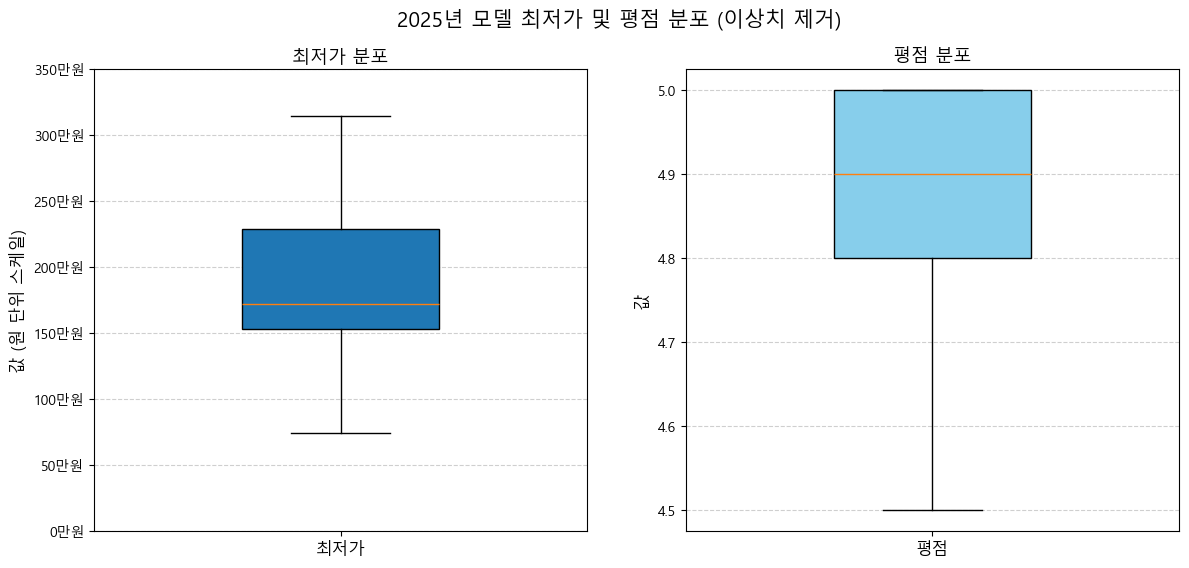

In [16]:
# EDA

# 구조보기
df = pd.read_csv('data.csv')
print(f"\n상위 5개 데이터:")
print(df.head())
print(df.shape)

# 기본통계량
print('LG:', df['모델명'].str.contains('LG').sum())
print('Samsung:', df['모델명'].str.contains('삼성').sum())
print('APPLE:', df['모델명'].str.contains('APPLE').sum())

# 결측치 탐색
print(df.isna().sum())

# CPU, 무게 중 하나라도 결측이면 삭제
df = df.dropna(subset=['CPU', '무게'])
print(f"\n결측치 제거 후 shape: {df.shape}")

# 이상치
df['최저가'] = pd.to_numeric(df['최저가'], errors='coerce') # 컬럼을 숫자(float)로 변환
df['평점'] = pd.to_numeric(df['평점'], errors='coerce') # 컬럼을 숫자(float)로 변환

# 파생 컬럼: 브랜드, 인기 
df['브랜드'] = df['모델명'].str.split(' ').str[0]
df['인기'] = pd.to_numeric(df['평점'], errors='coerce') * pd.to_numeric(df['댓글개수'], errors='coerce') # 숫자형으로 변환 

df['출시 연도'] = df['등록년월'].astype(str).str.split('.').str[0].astype(int)# 출시연도 파생 컬럼 추가
df['출시 연도'] = pd.to_numeric(df['출시 연도'], errors='coerce')

df.to_csv('data2.csv')

# 25년도 데이터 추출
df_2025 = df[df['등록년월'].str.startswith('2025')]

# 그 다음에 이상치 기준 계산
Q1 = df_2025['최저가'].quantile(0.25)# 하한
Q3 = df_2025['최저가'].quantile(0.75)# 상한 
IQR = Q3 - Q1

lower_bound_price = Q1 - 1.5 * IQR
upper_bound_price = Q3 + 1.5 * IQR
# outliers = df_2025[(df_2025['최저가'] < Q1 - 1.5 * IQR) | (df_2025['최저가'] > Q3 + 1.5 * IQR)]

Q1 = df_2025['평점'].quantile(0.25)# 하한
Q3 = df['평점'].quantile(0.75)# 상한 
IQR = Q3 - Q1

lower_bound_score = Q1 - 1.5 * IQR
upper_bound_score = Q3 + 1.5 * IQR
# outliers = df_2025[(df_2025['평점'] < Q1 - 1.5 * IQR) | (df_2025['평점'] > Q3 + 1.5 * IQR)]


df_2025_filtered = df_2025[
    (df_2025['최저가'] >= lower_bound_price) & 
    (df_2025['최저가'] <= upper_bound_price) &
    (df_2025['평점'] >= lower_bound_score) & 
    (df_2025['평점'] <= upper_bound_score)
].copy() # 이상치 제거 


print(f"전체 데이터 개수: {len(df)}")
print(f"2025년 데이터 개수: {len(df_2025)}")
print(f"2025년 이상치 제거 후 데이터 개수: {len(df_2025_filtered)}")

# 박스 플롯
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# # 데이터 준비 및 타입 변환
# data_to_plot = [
#     df_2025_filtered['최저가'].dropna().astype(float).tolist(),
#     df_2025_filtered['평점'].dropna().astype(float).tolist() # 평점은 숫자로 변환 필요
# ]

# 박스 플롯 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 최저가 박스플롯
bp1 = ax1.boxplot([df_2025_filtered['최저가'].dropna().astype(float).tolist()], patch_artist=True, widths=0.4) 

# 박스 색상 설정 (구분을 명확하게 하기 위해)
bp1['boxes'][0].set_facecolor('#1f77b4')

# X축 레이블 지정
ax1.set_xticks([1])
ax1.set_xticklabels(['최저가'], fontsize=12)

y_step = 500000 # 50만원 단위

# price_data의 최대값을 계산하여 50만원 단위로 올림
y_price_max = np.ceil(np.max(df_2025_filtered['최저가'].dropna().astype(float).tolist() ) / y_step) * y_step if df_2025_filtered['최저가'].dropna().astype(float).tolist()  else y_step

y_tick_locations = np.arange(0, y_price_max + y_step, y_step) # 0부터 최대값까지 y_step 간격으로 눈금 위치 생성
y_tick_labels = [f"{int(loc/10000):,}만원" for loc in y_tick_locations]
ax1.set_yticks(y_tick_locations)
ax1.set_yticklabels(y_tick_labels, fontsize=10)

# 제목 및 레이블 설정
ax1.set_title('최저가 분포', fontsize=13)
ax1.set_ylabel('값 (원 단위 스케일)', fontsize=12)
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)

# 평점 박스플롯
bp2 = ax2.boxplot([df_2025_filtered['평점'].dropna().astype(float).tolist()], patch_artist=True, widths=0.4)

# 박스 색상 설정
bp2['boxes'][0].set_facecolor('skyblue')

# X축 레이블 지정
ax2.set_xticks([1])
ax2.set_xticklabels(['평점'], fontsize=12)

# 제목 및 레이블 설정
ax2.set_title('평점 분포', fontsize=13)
ax2.set_ylabel('값', fontsize=12)
ax2.grid(True, axis='y', linestyle='--', alpha=0.6)

# 전체 제목
fig.suptitle('2025년 모델 최저가 및 평점 분포 (이상치 제거)', fontsize=15)




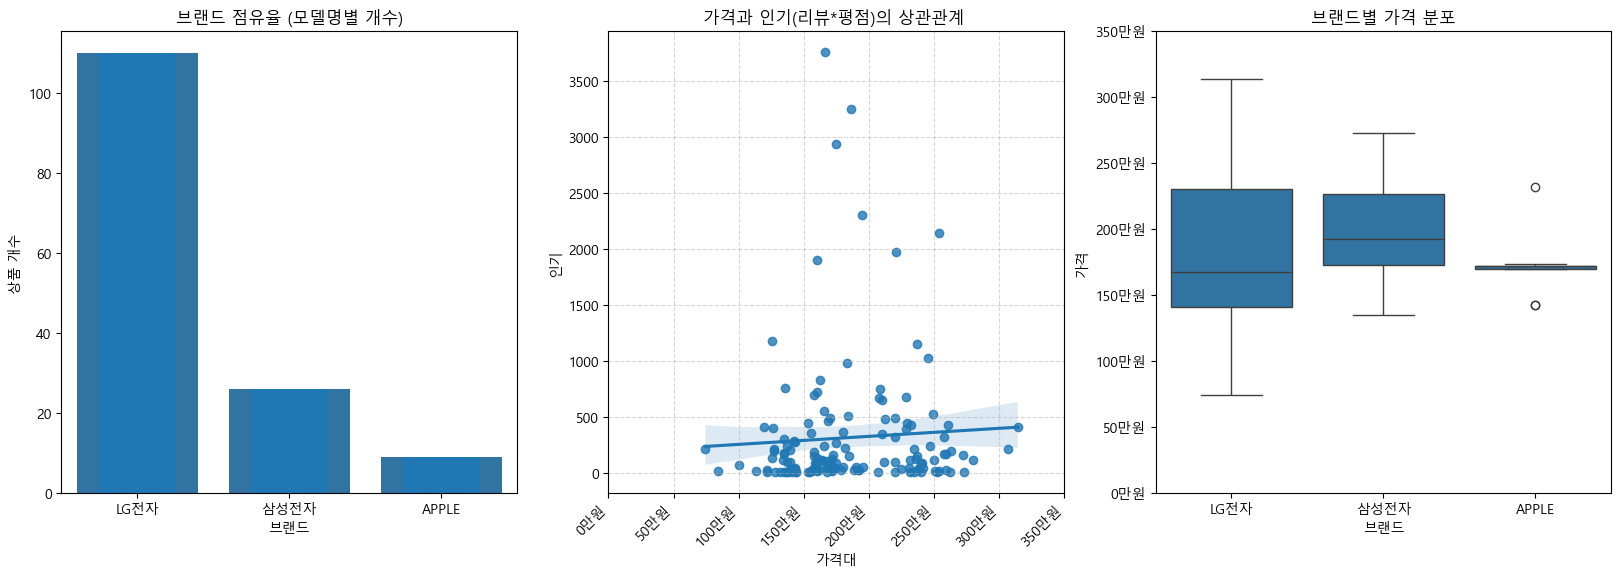

In [17]:
# 시각화
# 각 브랜드 별 갯수 
flg, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

sns.countplot(data=df_2025_filtered, x='브랜드', ax=ax1, order=df_2025_filtered['브랜드'].value_counts().index) # 브랜드를 제품 수가 많은 순서대로 정렬
df_2025_filtered['브랜드'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('브랜드 점유율 (모델명별 개수)')
ax1.set_xlabel('브랜드') # X축 라벨 설정
ax1.set_ylabel('상품 개수') # Y축 라벨 설정

max_count = df_2025_filtered['브랜드'].value_counts().max()
# np.arange를 사용하여 0부터 최대 개수 + 1까지 1 간격으로 눈금 설정
ax1.set_yticks(np.arange(0, max_count + 2, 20))
ax1.tick_params(axis='x', rotation=0) # x축 라벨 회전

# 가격과 인기의 상관관계 
sns.regplot(data=df_2025_filtered, x='최저가', y='인기', ax=ax2)

ax2.set_title('가격과 인기(리뷰*평점)의 상관관계 ')
ax2.set_xlabel('가격대') # X축 라벨 설정
ax2.set_ylabel('인기') # Y축 라벨 설정

# 💡 X축 눈금 간격 조정: 20만원 단위로 설정 (200,000 KRW)
price_min = df_2025_filtered['최저가'].min()
price_max = df_2025_filtered['최저가'].max()
step = 500000  # 20만원 단위

# 눈금 위치를 0부터 20만원 간격으로 설정하고, 가격 범위 내에 있는 눈금만 사용
# 시작을 0부터 하여 축의 원점을 명확하게 보여줍니다.
tick_locations = np.arange(0, price_max + step, step)
# 눈금 라벨을 '만원' 단위로 변환
tick_labels = [f"{int(loc/10000):,}만원" for loc in tick_locations]

# 눈금 및 라벨 적용
ax2.set_xticks(tick_locations)
ax2.set_xticklabels(tick_labels, rotation=45, ha='right')
ax2.grid(True, linestyle='--', alpha=0.5) # 그리드 표시

# 브랜드별 가격 분포
sns.boxplot(data=df_2025_filtered, x='브랜드', y='최저가', ax = ax3, order=df_2025_filtered['브랜드'].value_counts().index)
ax3.set_title('브랜드별 가격 분포')
ax3.set_xlabel('브랜드') # X축 라벨 설정00
ax3.set_ylabel('가격') # Y축 라벨 설정00

y_price_max = df_2025_filtered['최저가'].max()

y_step = 500000  # 50만원 단위
y_tick_locations = np.arange(0, y_price_max + y_step, y_step)
y_tick_labels = [f"{int(loc/10000):,}만원" for loc in y_tick_locations]

# Y축에 눈금 및 라벨 적용
ax3.set_yticks(y_tick_locations)
ax3.set_yticklabels(y_tick_labels)

plt.show()



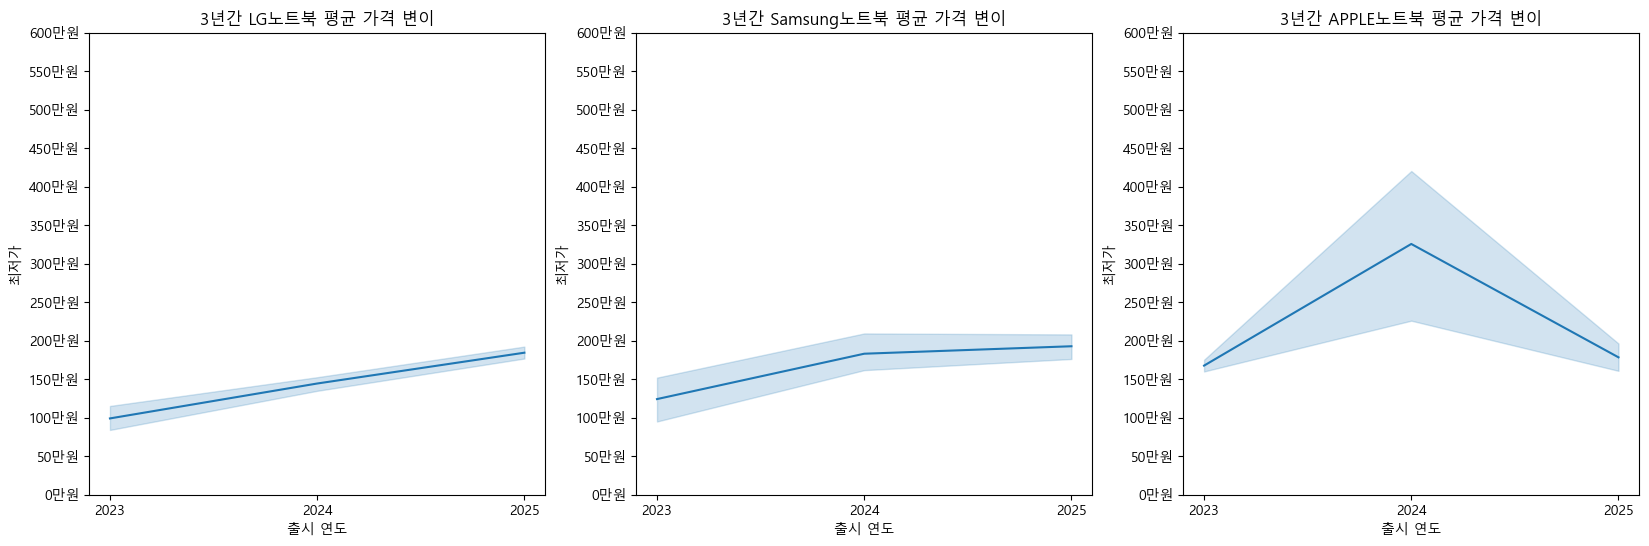

In [18]:
# 최근 3년간 3사 노트북 평균 가격 비교 선 그래프

df_recent = df[df['출시 연도'].isin([2023, 2024, 2025])]# 최근 3년거만 하드코딩

flg, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

y_step = 500000 # 50만원 단위
y_price_max = int(df_recent['최저가'].max())

yticks = range(0, int(df_recent['최저가'].max()) + 500000, 500000)
y_tick_locations = np.arange(0, y_price_max + y_step, y_step)
y_tick_labels = [f"{int(loc/10000):,}만원" for loc in y_tick_locations]


# seaborn의 lineplot은 명시적으로 평균 함수를 넣지 않아도 내부에서 자동으로 평균을 냄.
sns.lineplot(data=df_recent[df_recent['브랜드'] == 'LG전자'], x='출시 연도', y='최저가', ax=ax1) # LG
ax1.set_title('3년간 LG노트북 평균 가격 변이')
ax1.set_xlabel('출시 연도') # X축 라벨 설정
ax1.set_xticks([2023, 2024, 2025])
ax1.set_ylabel('최저가') # Y축 라벨 설정
ax1.set_yticks(y_tick_locations) # y축 눈금 위치를 직접 지정
ax1.set_yticklabels(y_tick_labels) # y축 눈금에 표시될 실제 라벨(문자열)을 지정

sns.lineplot(data=df_recent[df_recent['브랜드'] == '삼성전자'], x='출시 연도', y='최저가', ax=ax2) # Samsung
ax2.set_title('3년간 Samsung노트북 평균 가격 변이')
ax2.set_xlabel('출시 연도') # X축 라벨 설정
ax2.set_xticks([2023, 2024, 2025])
ax2.set_ylabel('최저가') # Y축 라벨 설정
ax2.set_yticks(y_tick_locations) # y축 눈금 위치를 직접 지정
ax2.set_yticklabels(y_tick_labels) # y축 눈금에 표시될 실제 라벨(문자열)을 지정

sns.lineplot(data=df_recent[df_recent['브랜드'] == 'APPLE'], x='출시 연도', y='최저가', ax=ax3) # APPLE
ax3.set_title('3년간 APPLE노트북 평균 가격 변이')
ax3.set_xlabel('출시 연도') # X축 라벨 설정
ax3.set_xticks([2023, 2024, 2025])
ax3.set_ylabel('최저가') # Y축 라벨 설정
ax3.set_yticks(y_tick_locations) # y축 눈금 위치를 직접 지정
ax3.set_yticklabels(y_tick_labels) # y축 눈금에 표시될 실제 라벨(문자열)을 지정
plt.show()



# 변수간 사
# 2026년도 3사 플래그쉽 모델 가격 예측

           화면크기        무게       RAM       SSD       최저가        평점        인기  \
화면크기   1.000000  0.138767  0.231319  0.052462  0.262066  0.072623  0.005566   
무게     0.138767  1.000000  0.117268  0.180850  0.089031 -0.096691 -0.071536   
RAM    0.231319  0.117268  1.000000  0.596906  0.726859  0.127387  0.025884   
SSD    0.052462  0.180850  0.596906  1.000000  0.681401  0.013493  0.088038   
최저가    0.262066  0.089031  0.726859  0.681401  1.000000  0.156411  0.039575   
평점     0.072623 -0.096691  0.127387  0.013493  0.156411  1.000000  0.047131   
인기     0.005566 -0.071536  0.025884  0.088038  0.039575  0.047131  1.000000   
출시 연도  0.076075 -0.395319  0.297698  0.130336  0.363789  0.221794 -0.021003   

          출시 연도  
화면크기   0.076075  
무게    -0.395319  
RAM    0.297698  
SSD    0.130336  
최저가    0.363789  
평점     0.221794  
인기    -0.021003  
출시 연도  1.000000  


'\n2025년 3사 상품중 LG전자의 상품이 제일 많았다.\n\n가격대와 인기는 약한 상관관계를 가졌다.\n--\n2025년 3사 상품가격 분포\nLG전자 150~250만원대.  \n삼성전자 170~225만원대\nAPPLE 150~200만원대\n--\nLG는 최근 3년간 평균가격이 조금씩 상승중\n삼성은 올해 평균 가격이 확 올랐다.\nAPPLE은 24년도 평균가격이 제일 높았고, 다시 하락했다. \n\n--\n느낀점 실제 사이트 웹크롤링은 예제 풀때 그 이상으로 힘들다.\n만약 .csv 형태 공공데이터로 진행했다면 하루는 단축 되었을것 같다.\n\n'

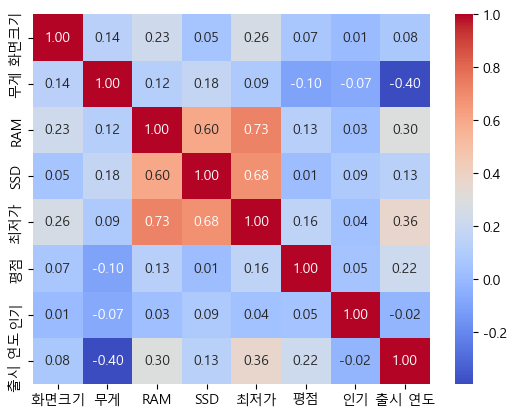

In [19]:
# 변수 상관관계 분석 (히트맵)

# 숫자형 변수만 선택
numeric_cols = ['최저가', '화면크기', '무게', 'RAM', 'SSD', '평점', '댓글개수']


# 실제 존재하는 컬럼만 필터링
numeric_cols_exist = [col for col in numeric_cols if col in df_2025_filtered.columns]

# 컬럼들 숫자형으로 변환
for col in numeric_cols_exist:
    df_2025_filtered[col] = pd.to_numeric(df_2025_filtered[col], errors='coerce')

# 결측치 제거 

# 상관계수 구하기
df_corr = df.corr(numeric_only=True)
print(df_corr)

# 히트맵 그리기
''' 
•annot: 실제 값도 각 칸에 출력할지 여부
•cmap: 색상 맵(팔레트)
•“viridis”, “cividis”, “coolwarm”, “plasma” 등
•fmt: 값 출력 포맷 문자열
•위 코드에서는 소수점 둘째 자리까지 출력
'''

sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f") # 1이나 -1에 가까울수록 상관관계가 있다는 것, 

# 인사이트 도출
'''
2025년 3사 상품중 LG전자의 상품이 제일 많았다.

가격대와 인기는 약한 상관관계를 가졌다.
--
2025년 3사 상품가격 분포
LG전자 150~250만원대.  
삼성전자 170~225만원대
APPLE 150~200만원대
--
LG는 최근 3년간 평균가격이 조금씩 상승중
삼성은 올해 평균 가격이 확 올랐다.
APPLE은 24년도 평균가격이 제일 높았고, 다시 하락했다. 

--
느낀점 실제 사이트 웹크롤링은 예제 풀때 그 이상으로 힘들다.
만약 .csv 형태 공공데이터로 진행했다면 하루는 단축 되었을것 같다.

'''
